In [ ]:
# 1. Install required packages
!pip install langchain openai duckduckgo-search faiss-cpu sentence-transformers torch transformers datasets pandas tqdm scikit-learn seaborn langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# 2. Imports
import os
import zipfile
import random
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

from google.colab import files

In [ ]:
# 3. Upload & extract dataset
print("📁 Please upload your dataset.zip file (contains the fake/real CSVs)...")
uploaded = files.upload()

dataset_zip_path = next(iter(uploaded))
extract_path = "./dataset_extracted"
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(f"✅ Extracted to: {extract_path}")

📁 Please upload your dataset.zip file (contains the fake/real CSVs)...


Saving dataset.zip to dataset.zip
✅ Extracted to: ./dataset_extracted


In [ ]:
# 4. Clean, balance & augment
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip().lower()

def augment_text(text):
    words = text.split()
    if len(words) < 2:
        return text
    random.shuffle(words)
    return ' '.join(words)

def prepare_data(balance=True, augment=False):
    # Load all four CSVs
    base_path = f"{extract_path}/dataset"
    df_list = []
    for source in ["gossipcop", "politifact"]:
        for label_type, label in [("fake", 1), ("real", 0)]:
            csv_path = f"{base_path}/{source}_{label_type}.csv"
            df = pd.read_csv(csv_path)
            df["label"] = label
            df_list.append(df)

    df = pd.concat(df_list, ignore_index=True)

    # Use "title" or "text" columns based on availability
    text_col = "title" if "title" in df.columns else "text"
    df["text"] = df[text_col].fillna("").apply(clean_text)

    # Drop empty rows
    df = df[df["text"].str.strip().astype(bool)]

    # Balance classes
    if balance:
        fake_df = df[df["label"] == 1]
        real_df = df[df["label"] == 0]
        min_len = min(len(fake_df), len(real_df))

        fake_df = fake_df.sample(min_len, random_state=42)
        real_df = real_df.sample(min_len, random_state=42)

        df = pd.concat([fake_df, real_df]).sample(frac=1, random_state=42)

    # Augment if needed
    if augment:
        augmented_texts, augmented_labels = [], []
        for text, label in zip(df["text"], df["label"]):
            augmented_texts.append(text)
            augmented_labels.append(label)
            augmented_texts.append(augment_text(text))
            augmented_labels.append(label)
        df = pd.DataFrame({"text": augmented_texts, "label": augmented_labels})

    return train_test_split(df["text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42, stratify=df["label"])

In [ ]:
# 5. Dataset + Model
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

class LSTMClassifier(nn.Module):
    def __init__(self, hidden_dim=128):
        super(LSTMClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        lstm_out, _ = self.lstm(outputs.last_hidden_state)
        final_feature = lstm_out[:, -1, :]
        return self.fc(final_feature)

In [ ]:
# 6. Training + Evaluation
def train_and_evaluate(X_train, X_test, y_train, y_test,epochs  = 20):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    train_ds = TextDataset(X_train, y_train, tokenizer)
    test_ds = TextDataset(X_test, y_test, tokenizer)

    train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=16)

    model = LSTMClassifier()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    all_losses = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_dl, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_dl)
        all_losses.append(avg_loss)
        print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for batch in test_dl:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            pred = torch.argmax(outputs, dim=1).cpu().numpy()
            preds.extend(pred)
            true.extend(batch['label'].numpy())

    print("\nClassification Report:")
    print(classification_report(true, preds, target_names=["Real", "Fake"]))

    # Loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), all_losses, marker='o', label="Training Loss")
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    return model, test_dl



In [ ]:
# 7. Run Everything
print("🚀 Preparing data...")
X_train, X_test, y_train, y_test = prepare_data(balance=True, augment=True)

🚀 Preparing data...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 1151/1151 [02:14<00:00,  8.57it/s]


Epoch 1 Average Loss: 0.6051


Epoch 2: 100%|██████████| 1151/1151 [02:22<00:00,  8.09it/s]


Epoch 2 Average Loss: 0.5584


Epoch 3: 100%|██████████| 1151/1151 [02:22<00:00,  8.08it/s]


Epoch 3 Average Loss: 0.5358


Epoch 4: 100%|██████████| 1151/1151 [02:22<00:00,  8.09it/s]


Epoch 4 Average Loss: 0.5201


Epoch 5: 100%|██████████| 1151/1151 [02:22<00:00,  8.07it/s]


Epoch 5 Average Loss: 0.5068


Epoch 6: 100%|██████████| 1151/1151 [02:22<00:00,  8.07it/s]


Epoch 6 Average Loss: 0.4932


Epoch 7: 100%|██████████| 1151/1151 [02:22<00:00,  8.08it/s]


Epoch 7 Average Loss: 0.4823


Epoch 8: 100%|██████████| 1151/1151 [02:22<00:00,  8.07it/s]


Epoch 8 Average Loss: 0.4709


Epoch 9: 100%|██████████| 1151/1151 [02:22<00:00,  8.08it/s]


Epoch 9 Average Loss: 0.4543


Epoch 10: 100%|██████████| 1151/1151 [02:22<00:00,  8.09it/s]


Epoch 10 Average Loss: 0.4420


Epoch 11: 100%|██████████| 1151/1151 [02:22<00:00,  8.06it/s]


Epoch 11 Average Loss: 0.4280


Epoch 12: 100%|██████████| 1151/1151 [02:22<00:00,  8.09it/s]


Epoch 12 Average Loss: 0.4167


Epoch 13: 100%|██████████| 1151/1151 [02:22<00:00,  8.06it/s]


Epoch 13 Average Loss: 0.4062


Epoch 14: 100%|██████████| 1151/1151 [02:22<00:00,  8.07it/s]


Epoch 14 Average Loss: 0.3947


Epoch 15: 100%|██████████| 1151/1151 [02:23<00:00,  8.04it/s]


Epoch 15 Average Loss: 0.3819


Epoch 16: 100%|██████████| 1151/1151 [02:22<00:00,  8.06it/s]


Epoch 16 Average Loss: 0.3754


Epoch 17: 100%|██████████| 1151/1151 [02:22<00:00,  8.07it/s]


Epoch 17 Average Loss: 0.3672


Epoch 18: 100%|██████████| 1151/1151 [02:22<00:00,  8.06it/s]


Epoch 18 Average Loss: 0.3554


Epoch 19: 100%|██████████| 1151/1151 [02:22<00:00,  8.07it/s]


Epoch 19 Average Loss: 0.3419


Epoch 20: 100%|██████████| 1151/1151 [02:22<00:00,  8.07it/s]


Epoch 20 Average Loss: 0.3448

Classification Report:
              precision    recall  f1-score   support

        Real       0.79      0.79      0.79      2302
        Fake       0.79      0.78      0.79      2302

    accuracy                           0.79      4604
   macro avg       0.79      0.79      0.79      4604
weighted avg       0.79      0.79      0.79      4604



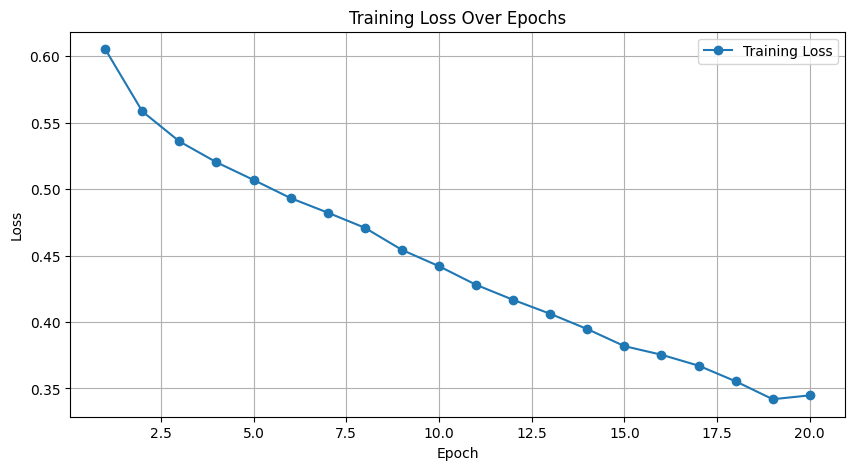

In [ ]:
model, test_dl = train_and_evaluate(X_train, X_test, y_train, y_test, epochs=20)


Classification Report:
              precision    recall  f1-score   support

        Real       0.79      0.79      0.79      2302
        Fake       0.79      0.78      0.79      2302

    accuracy                           0.79      4604
   macro avg       0.79      0.79      0.79      4604
weighted avg       0.79      0.79      0.79      4604



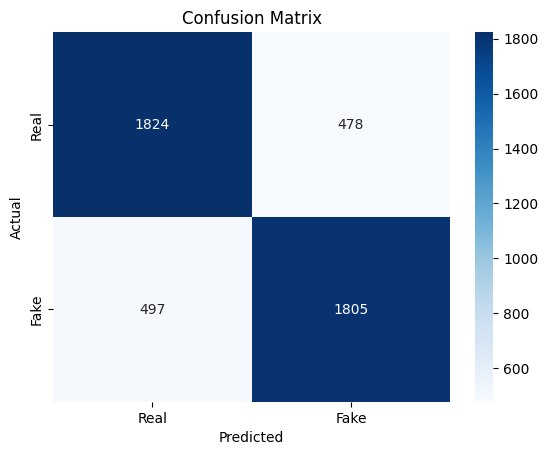

In [ ]:
# Evaluate model and show confusion matrix
def evaluate_model(model, test_dl):
    model.eval()
    preds, true = [], []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for batch in test_dl:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            pred = torch.argmax(outputs, dim=1).cpu().numpy()
            preds.extend(pred)
            true.extend(batch['label'].numpy())

    print("\nClassification Report:")
    print(classification_report(true, preds, target_names=["Real", "Fake"]))

    cm = confusion_matrix(true, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# 🔁 Recreate test loader and model instance (must match training)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
test_ds = TextDataset(X_test, y_test, tokenizer)
test_dl = DataLoader(test_ds, batch_size=16)

# ⚠️ Make sure 'model' is still in memory from training
evaluate_model(model, test_dl)


In [ ]:
# 6. BERT + CNN model
class BERTCNNClassifier(nn.Module):
    def __init__(self, hidden_dim=128, filter_sizes=[3, 4, 5], num_filters=100):
        super(BERTCNNClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, 768)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state.unsqueeze(1)  # [B, 1, T, 768]
        conved = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]  # [B, F, T-F+1]
        pooled = [torch.max(c, dim=2)[0] for c in conved]  # [B, F]
        cat = torch.cat(pooled, dim=1)  # [B, F * len(filter_sizes)]
        return self.fc(cat)

In [ ]:

# 7. Training + Evaluation + Loss Plotting
def train_and_evaluate(X_train, X_test, y_train, y_test, epochs=20):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    train_ds = TextDataset(X_train, y_train, tokenizer)
    test_ds = TextDataset(X_test, y_test, tokenizer)
    train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=16)

    model = BERTCNNClassifier()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    all_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_dl, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_dl)
        all_losses.append(avg_loss)
        print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

    # Loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), all_losses, marker='o', label="Training Loss")
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    return model, test_dl

Epoch 1: 100%|██████████| 1151/1151 [02:30<00:00,  7.63it/s]


Epoch 1 Average Loss: 0.5646


Epoch 2: 100%|██████████| 1151/1151 [02:28<00:00,  7.77it/s]


Epoch 2 Average Loss: 0.5078


Epoch 3: 100%|██████████| 1151/1151 [02:28<00:00,  7.74it/s]


Epoch 3 Average Loss: 0.4711


Epoch 4: 100%|██████████| 1151/1151 [02:28<00:00,  7.75it/s]


Epoch 4 Average Loss: 0.4365


Epoch 5: 100%|██████████| 1151/1151 [02:28<00:00,  7.73it/s]


Epoch 5 Average Loss: 0.3972


Epoch 6: 100%|██████████| 1151/1151 [02:28<00:00,  7.74it/s]


Epoch 6 Average Loss: 0.3597


Epoch 7: 100%|██████████| 1151/1151 [02:28<00:00,  7.75it/s]


Epoch 7 Average Loss: 0.3227


Epoch 8: 100%|██████████| 1151/1151 [02:28<00:00,  7.73it/s]


Epoch 8 Average Loss: 0.2882


Epoch 9: 100%|██████████| 1151/1151 [02:28<00:00,  7.75it/s]


Epoch 9 Average Loss: 0.2564


Epoch 10: 100%|██████████| 1151/1151 [02:28<00:00,  7.74it/s]


Epoch 10 Average Loss: 0.2271


Epoch 11: 100%|██████████| 1151/1151 [02:28<00:00,  7.74it/s]


Epoch 11 Average Loss: 0.2002


Epoch 12: 100%|██████████| 1151/1151 [02:28<00:00,  7.74it/s]


Epoch 12 Average Loss: 0.1848


Epoch 13: 100%|██████████| 1151/1151 [02:28<00:00,  7.75it/s]


Epoch 13 Average Loss: 0.1582


Epoch 14: 100%|██████████| 1151/1151 [02:28<00:00,  7.76it/s]


Epoch 14 Average Loss: 0.1400


Epoch 15: 100%|██████████| 1151/1151 [02:28<00:00,  7.76it/s]


Epoch 15 Average Loss: 0.1268


Epoch 16: 100%|██████████| 1151/1151 [02:28<00:00,  7.76it/s]


Epoch 16 Average Loss: 0.1131


Epoch 17: 100%|██████████| 1151/1151 [02:28<00:00,  7.75it/s]


Epoch 17 Average Loss: 0.0984


Epoch 18: 100%|██████████| 1151/1151 [02:28<00:00,  7.74it/s]


Epoch 18 Average Loss: 0.0900


Epoch 19: 100%|██████████| 1151/1151 [02:28<00:00,  7.73it/s]


Epoch 19 Average Loss: 0.0862


Epoch 20: 100%|██████████| 1151/1151 [02:28<00:00,  7.75it/s]


Epoch 20 Average Loss: 0.0784


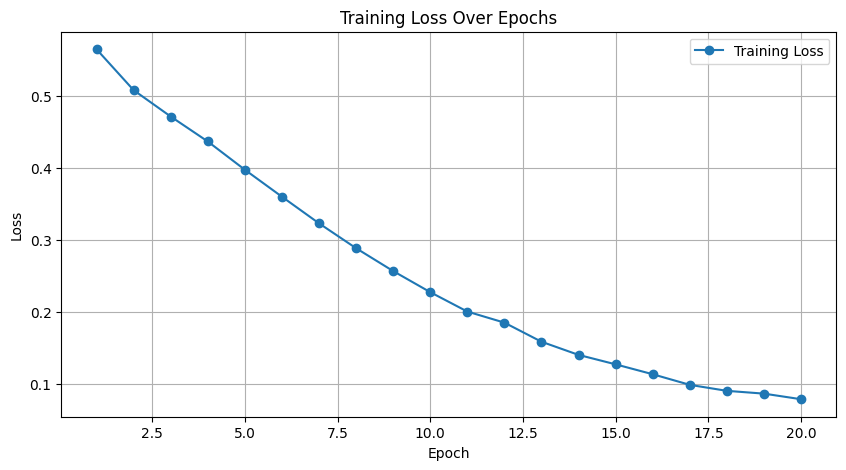

In [ ]:
model, test_dl = train_and_evaluate(X_train, X_test, y_train, y_test, epochs=20)


Classification Report:
              precision    recall  f1-score   support

        Real       0.84      0.68      0.75      2302
        Fake       0.73      0.87      0.80      2302

    accuracy                           0.78      4604
   macro avg       0.79      0.78      0.78      4604
weighted avg       0.79      0.78      0.78      4604



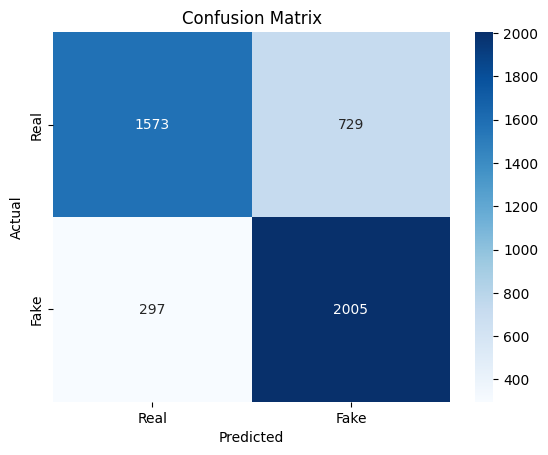

In [ ]:
evaluate_model(model, test_dl)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, dataloader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Real", "Fake"]))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return acc, prec, rec, f1


🚀 Training BERT + CNN...


Epoch 1: 100%|██████████| 1151/1151 [02:28<00:00,  7.73it/s]


Epoch 1 Average Loss: 0.5690


Epoch 2: 100%|██████████| 1151/1151 [02:28<00:00,  7.74it/s]


Epoch 2 Average Loss: 0.5107


Epoch 3: 100%|██████████| 1151/1151 [02:28<00:00,  7.75it/s]


Epoch 3 Average Loss: 0.4686


Epoch 4: 100%|██████████| 1151/1151 [02:28<00:00,  7.75it/s]


Epoch 4 Average Loss: 0.4304


Epoch 5: 100%|██████████| 1151/1151 [02:28<00:00,  7.75it/s]


Epoch 5 Average Loss: 0.3934


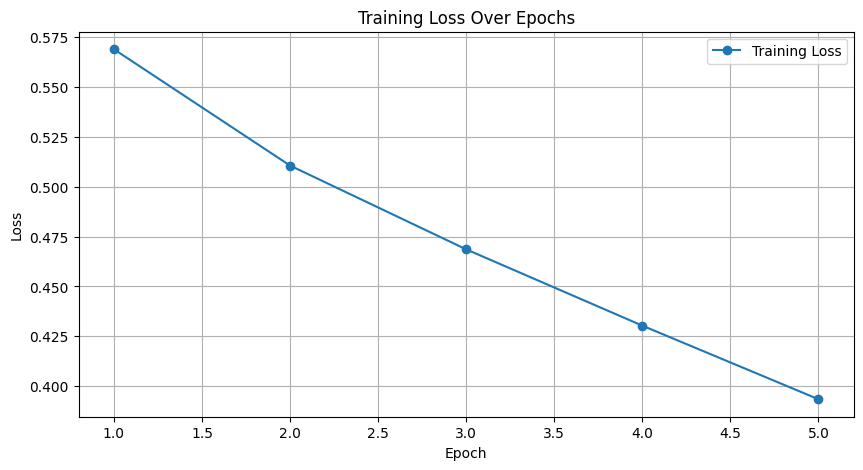


📊 Classification Report:
              precision    recall  f1-score   support

        Real       0.81      0.73      0.77      2302
        Fake       0.75      0.83      0.79      2302

    accuracy                           0.78      4604
   macro avg       0.78      0.78      0.78      4604
weighted avg       0.78      0.78      0.78      4604



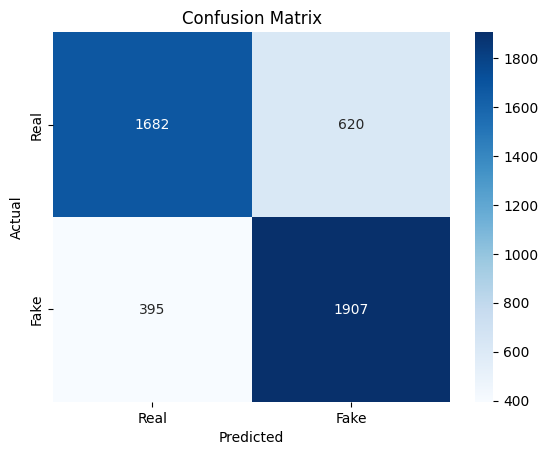

🚀 Training BERT + LSTM...


Epoch 1: 100%|██████████| 1151/1151 [02:28<00:00,  7.74it/s]


Epoch 1 Average Loss: 0.5684


Epoch 2: 100%|██████████| 1151/1151 [02:28<00:00,  7.76it/s]


Epoch 2 Average Loss: 0.5080


Epoch 3: 100%|██████████| 1151/1151 [02:28<00:00,  7.73it/s]


Epoch 3 Average Loss: 0.4684


Epoch 4: 100%|██████████| 1151/1151 [02:28<00:00,  7.73it/s]


Epoch 4 Average Loss: 0.4296


Epoch 5: 100%|██████████| 1151/1151 [02:28<00:00,  7.74it/s]


Epoch 5 Average Loss: 0.3965


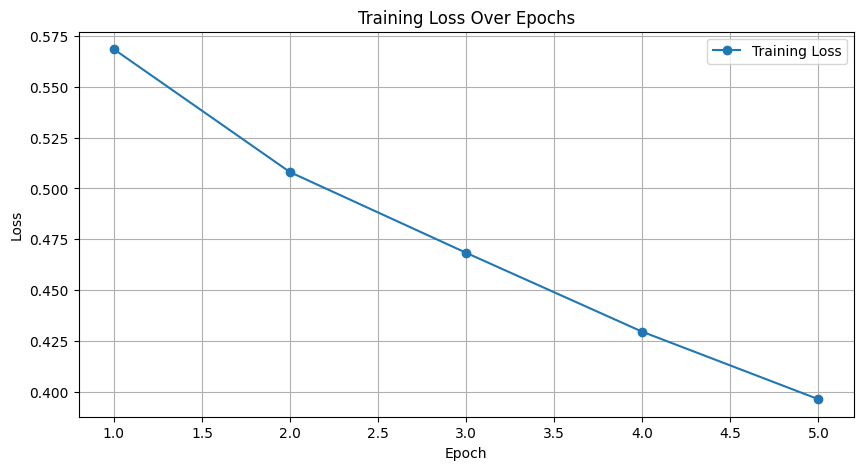


📊 Classification Report:
              precision    recall  f1-score   support

        Real       0.88      0.52      0.65      2302
        Fake       0.66      0.93      0.77      2302

    accuracy                           0.72      4604
   macro avg       0.77      0.72      0.71      4604
weighted avg       0.77      0.72      0.71      4604



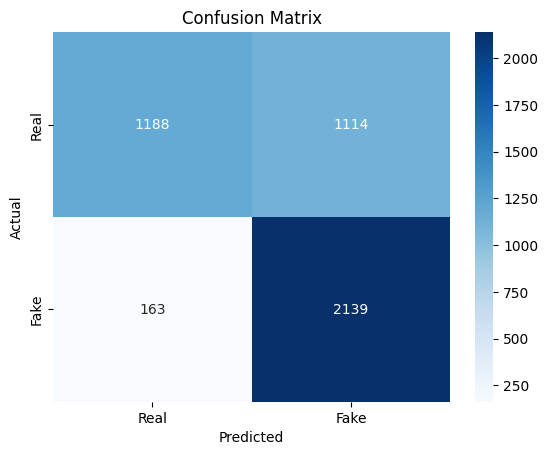


📊 Model Comparison Table:
             Accuracy  Precision    Recall  F1-Score
BERT + CNN   0.779540   0.754650  0.828410  0.789812
BERT + LSTM  0.722632   0.657547  0.929192  0.770117


In [ ]:
# BERT + CNN
print("🚀 Training BERT + CNN...")
cnn_model, test_dl = train_and_evaluate(X_train, X_test, y_train, y_test, epochs=5)
cnn_metrics = evaluate_model(cnn_model, test_dl)

# BERT + LSTM
print("🚀 Training BERT + LSTM...")
lstm_model = LSTMClassifier()
lstm_model, test_dl = train_and_evaluate(X_train, X_test, y_train, y_test, epochs=5)
lstm_metrics = evaluate_model(lstm_model, test_dl)

# Create Comparison Table
comparison = pd.DataFrame(
    [cnn_metrics, lstm_metrics],
    columns=["Accuracy", "Precision", "Recall", "F1-Score"],
    index=["BERT + CNN", "BERT + LSTM"]
)

print("\n📊 Model Comparison Table:")
print(comparison)


🚀 Training BERT + CNN...


Epoch 1: 100%|██████████| 1151/1151 [02:28<00:00,  7.75it/s]


Epoch 1 Average Loss: 0.5652


Epoch 2: 100%|██████████| 1151/1151 [02:28<00:00,  7.76it/s]


Epoch 2 Average Loss: 0.5105


Epoch 3: 100%|██████████| 1151/1151 [02:28<00:00,  7.76it/s]


Epoch 3 Average Loss: 0.4729


Epoch 4: 100%|██████████| 1151/1151 [02:28<00:00,  7.75it/s]


Epoch 4 Average Loss: 0.4369


Epoch 5: 100%|██████████| 1151/1151 [02:28<00:00,  7.77it/s]


Epoch 5 Average Loss: 0.3999


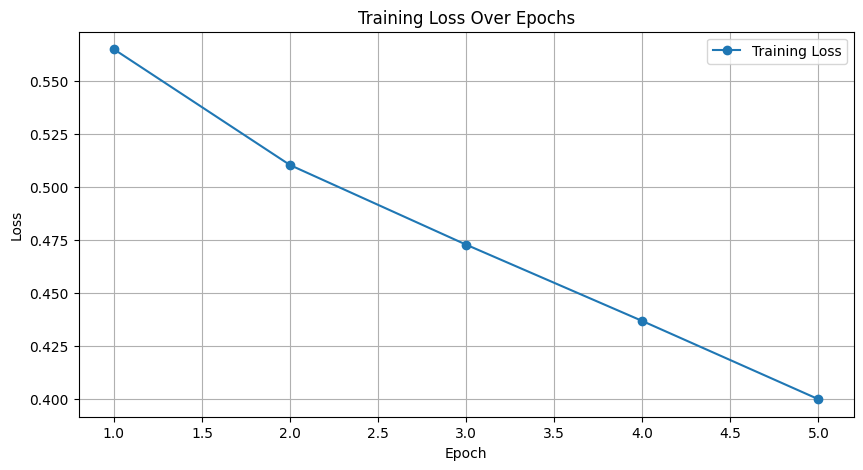


🔧 Optimal threshold for F1: 0.60

📊 Classification Report:
              precision    recall  f1-score   support

        Real       0.81      0.76      0.78      2302
        Fake       0.77      0.82      0.79      2302

    accuracy                           0.79      4604
   macro avg       0.79      0.79      0.79      4604
weighted avg       0.79      0.79      0.79      4604



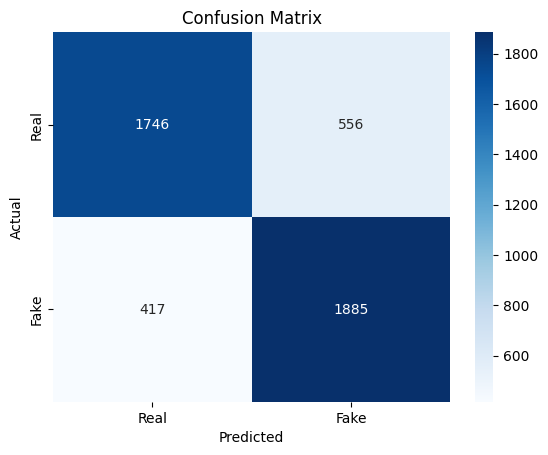

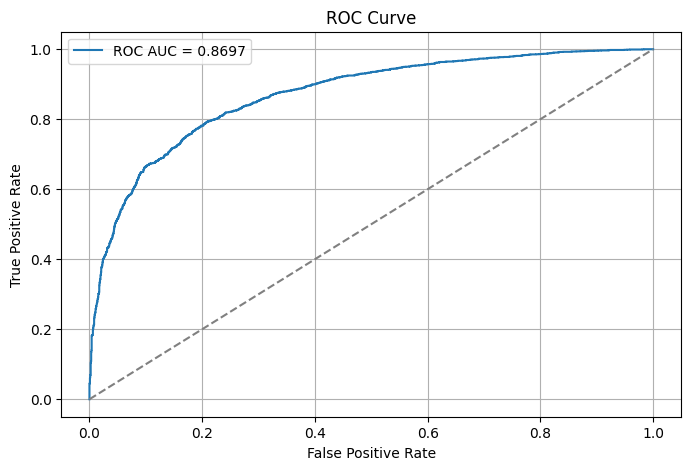

🚀 Training BERT + LSTM...


Epoch 1: 100%|██████████| 1151/1151 [02:29<00:00,  7.72it/s]


Epoch 1 Average Loss: 0.5704


Epoch 2: 100%|██████████| 1151/1151 [02:28<00:00,  7.73it/s]


Epoch 2 Average Loss: 0.5132


Epoch 3: 100%|██████████| 1151/1151 [02:29<00:00,  7.72it/s]


Epoch 3 Average Loss: 0.4727


Epoch 4: 100%|██████████| 1151/1151 [02:29<00:00,  7.70it/s]


Epoch 4 Average Loss: 0.4364


Epoch 5: 100%|██████████| 1151/1151 [02:29<00:00,  7.71it/s]


Epoch 5 Average Loss: 0.4013


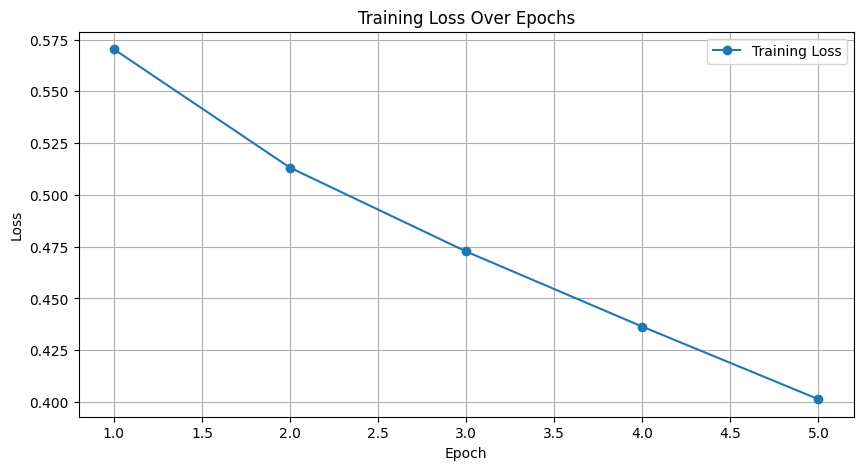


🔧 Optimal threshold for F1: 0.45

📊 Classification Report:
              precision    recall  f1-score   support

        Real       0.81      0.75      0.78      2302
        Fake       0.77      0.82      0.79      2302

    accuracy                           0.79      4604
   macro avg       0.79      0.79      0.79      4604
weighted avg       0.79      0.79      0.79      4604



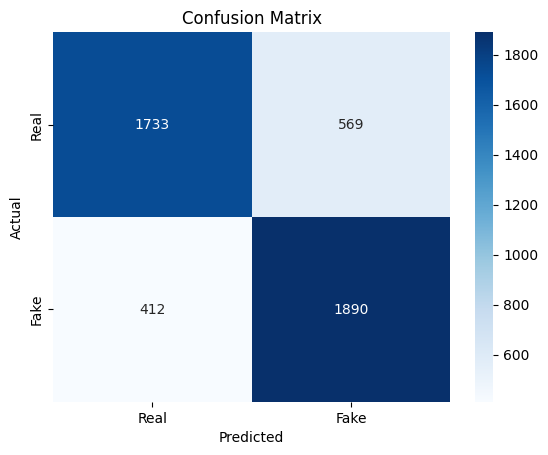

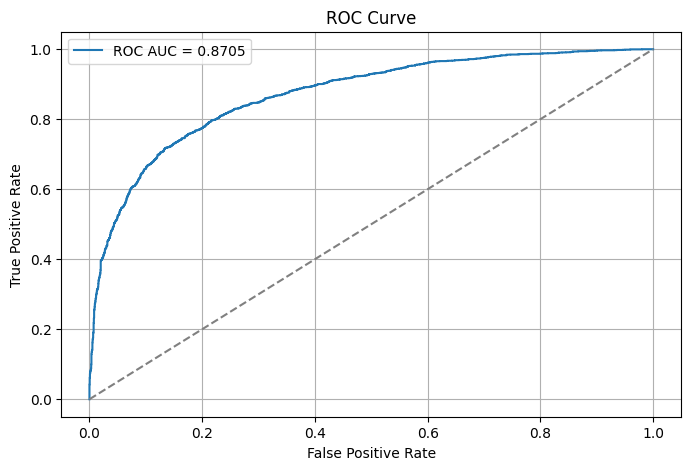


📊 Model Comparison Table:
             Accuracy  Precision    Recall  F1-Score   ROC-AUC
BERT + CNN   0.788662   0.772224  0.818853  0.794856  0.869653
BERT + LSTM  0.786924   0.768605  0.821025  0.793951  0.870467


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix
)

def evaluate_model(model, dataloader, optimize_threshold=False):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            logits = outputs.softmax(dim=1)[:, 1]  # Class 1 probability (Fake)
            all_logits.extend(logits.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # F1 Optimization
    if optimize_threshold:
        thresholds = np.linspace(0.1, 0.9, 81)
        best_f1 = 0
        best_threshold = 0.5
        for t in thresholds:
            preds = [1 if p >= t else 0 for p in all_logits]
            f1 = f1_score(all_labels, preds)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = t
        print(f"\n🔧 Optimal threshold for F1: {best_threshold:.2f}")
    else:
        best_threshold = 0.5

    preds = [1 if p >= best_threshold else 0 for p in all_logits]

    acc = accuracy_score(all_labels, preds)
    prec = precision_score(all_labels, preds)
    rec = recall_score(all_labels, preds)
    f1 = f1_score(all_labels, preds)
    roc_auc = roc_auc_score(all_labels, all_logits)

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, preds, target_names=["Real", "Fake"]))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_logits)
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    return acc, prec, rec, f1, roc_auc


# 🔁 Train and Evaluate Both Models
print("🚀 Training BERT + CNN...")
cnn_model, test_dl = train_and_evaluate(X_train, X_test, y_train, y_test, epochs=5)
cnn_metrics = evaluate_model(cnn_model, test_dl, optimize_threshold=True)

print("🚀 Training BERT + LSTM...")
lstm_model = LSTMClassifier()
lstm_model, test_dl = train_and_evaluate(X_train, X_test, y_train, y_test, epochs=5)
lstm_metrics = evaluate_model(lstm_model, test_dl, optimize_threshold=True)

# 📊 Comparison Table
comparison_df = pd.DataFrame(
    [cnn_metrics, lstm_metrics],
    columns=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"],
    index=["BERT + CNN", "BERT + LSTM"]
)

print("\n📊 Model Comparison Table:")
print(comparison_df)


In [ ]:
import time

def train_and_evaluate(X_train, X_test, y_train, y_test, epochs=5):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    train_ds = TextDataset(X_train, y_train, tokenizer)
    test_ds = TextDataset(X_test, y_test, tokenizer)
    train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=16)

    model = BERTCNNClassifier() if "CNN" in globals() else LSTMClassifier()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    all_losses = []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_dl, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_dl)
        all_losses.append(avg_loss)
        print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

    end_time = time.time()
    training_time = end_time - start_time

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), all_losses, marker='o', label="Training Loss")
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    return model, test_dl, training_time


🚀 Training BERT + CNN...


Epoch 1: 100%|██████████| 1151/1151 [02:22<00:00,  8.08it/s]


Epoch 1 Average Loss: 0.6036


Epoch 2: 100%|██████████| 1151/1151 [02:22<00:00,  8.09it/s]


Epoch 2 Average Loss: 0.5601


Epoch 3: 100%|██████████| 1151/1151 [02:21<00:00,  8.11it/s]


Epoch 3 Average Loss: 0.5398


Epoch 4: 100%|██████████| 1151/1151 [02:22<00:00,  8.09it/s]


Epoch 4 Average Loss: 0.5195


Epoch 5: 100%|██████████| 1151/1151 [02:21<00:00,  8.11it/s]


Epoch 5 Average Loss: 0.5088


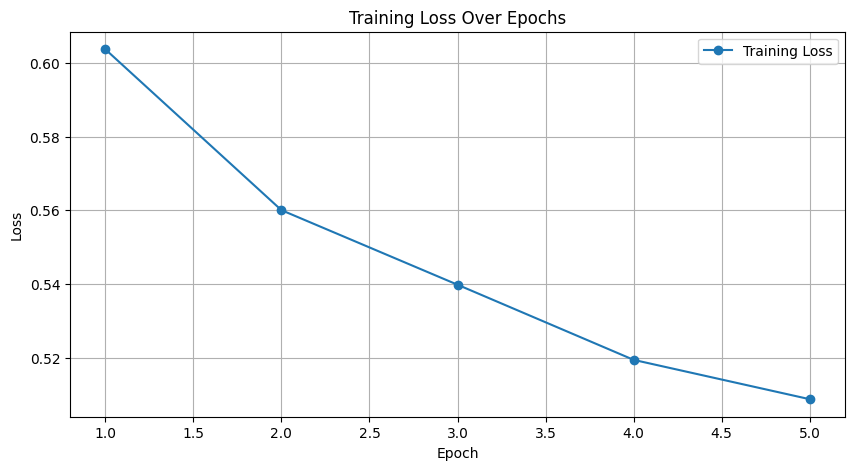


🔧 Optimal threshold for F1: 0.39

📊 Classification Report:
              precision    recall  f1-score   support

        Real       0.80      0.62      0.70      2302
        Fake       0.69      0.85      0.76      2302

    accuracy                           0.73      4604
   macro avg       0.75      0.73      0.73      4604
weighted avg       0.75      0.73      0.73      4604



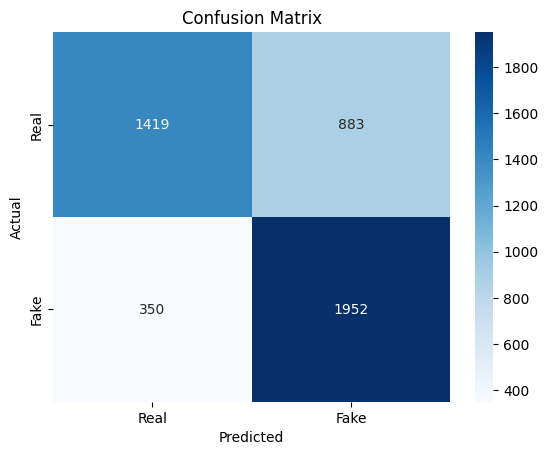

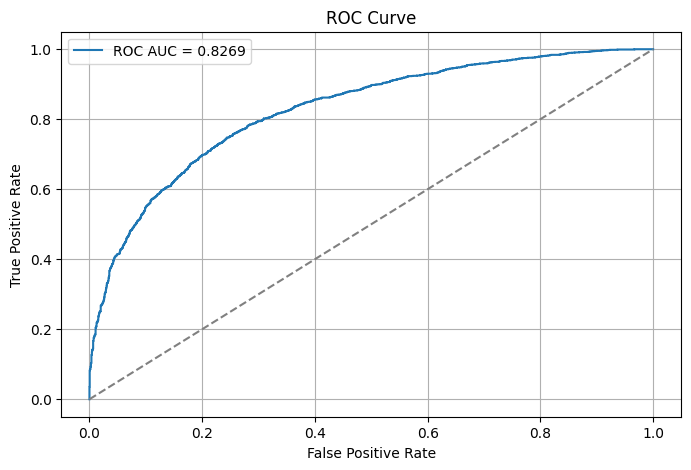

🚀 Training BERT + LSTM...


Epoch 1: 100%|██████████| 1151/1151 [02:22<00:00,  8.06it/s]


Epoch 1 Average Loss: 0.5995


Epoch 2: 100%|██████████| 1151/1151 [02:22<00:00,  8.07it/s]


Epoch 2 Average Loss: 0.5578


Epoch 3: 100%|██████████| 1151/1151 [02:22<00:00,  8.06it/s]


Epoch 3 Average Loss: 0.5374


Epoch 4: 100%|██████████| 1151/1151 [02:22<00:00,  8.07it/s]


Epoch 4 Average Loss: 0.5189


Epoch 5: 100%|██████████| 1151/1151 [02:22<00:00,  8.07it/s]


Epoch 5 Average Loss: 0.5046


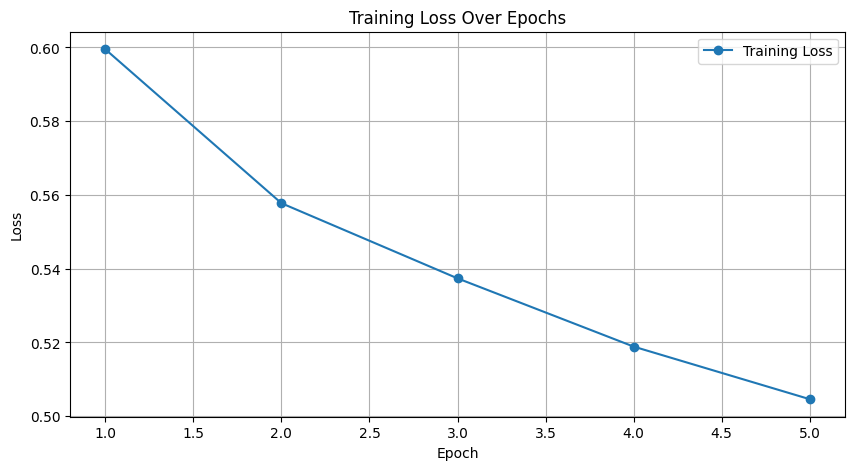


🔧 Optimal threshold for F1: 0.35

📊 Classification Report:
              precision    recall  f1-score   support

        Real       0.81      0.59      0.68      2302
        Fake       0.68      0.86      0.76      2302

    accuracy                           0.73      4604
   macro avg       0.74      0.73      0.72      4604
weighted avg       0.74      0.73      0.72      4604



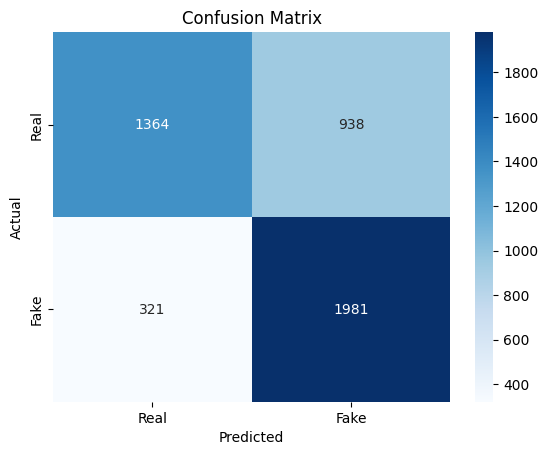

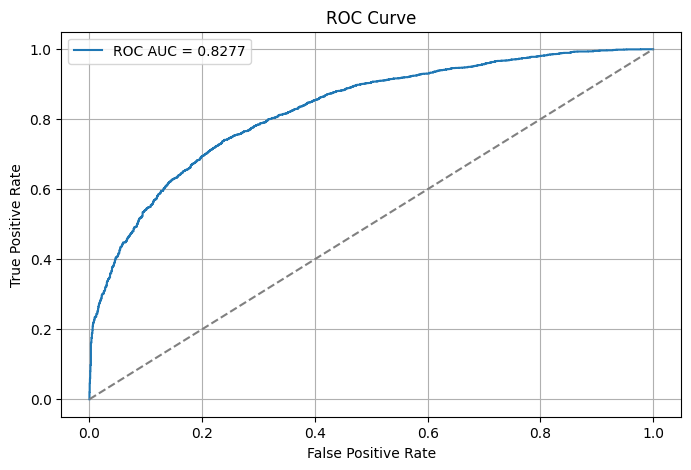


📊 Model Comparison Table:
             Accuracy  Precision  Recall  F1-Score  ROC-AUC  Train Time (s)
BERT + CNN     0.7322     0.6885  0.8480    0.7600   0.8269        710.9978
BERT + LSTM    0.7265     0.6787  0.8606    0.7589   0.8277        713.5794


In [ ]:
# 🔁 Train and Evaluate Both Models
print("🚀 Training BERT + CNN...")
cnn_model, test_dl, cnn_time = train_and_evaluate(X_train, X_test, y_train, y_test, epochs=5)
cnn_metrics = evaluate_model(cnn_model, test_dl, optimize_threshold=True)

print("🚀 Training BERT + LSTM...")
lstm_model = LSTMClassifier()
lstm_model, test_dl, lstm_time = train_and_evaluate(X_train, X_test, y_train, y_test, epochs=5)
lstm_metrics = evaluate_model(lstm_model, test_dl, optimize_threshold=True)

# 📊 Comparison Table
comparison_df = pd.DataFrame(
    [cnn_metrics + (cnn_time,), lstm_metrics + (lstm_time,)],
    columns=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Train Time (s)"],
    index=["BERT + CNN", "BERT + LSTM"]
)

print("\n📊 Model Comparison Table:")
print(comparison_df.round(4))
